In [84]:
import os
import chess.pgn
from datetime import datetime

print('Preloading games...')
limit = 10000
games = []

for path in os.listdir("datasets"):
    with open(f'datasets/{path}') as file:
        while len(games) < limit:
            game = chess.pgn.read_game(file)
            if game is None:
                break

            date = game.headers.get('UTCDate')  # 2012.12.31
            time = game.headers.get('UTCTime')  # 23:04:12

            ts_game = {
                'id': game.headers.get('Site').split('/')[-1],  # [Site "https://lichess.org/j1dkb5dw"]
                'link': game.headers.get('Site'),
                'timestamp_utc': int(datetime.strptime(f'{date} {time}', '%Y.%m.%d %H:%M:%S').timestamp()),
                'event': game.headers.get('Event'),
                'white': game.headers.get('White'),
                'black': game.headers.get('Black'),
                'opening': game.headers.get('Opening'),
                'termination': game.headers.get('Termination'),
                'mainline_moves': str(game.mainline_moves()),
            }

            games.append(ts_game)
print('Loaded {} games'.format(len(games)))


def print_game(game):
    print(f"{game['white']} vs {game['black']} ({game['event']})")
    print(game['link'])
    print(game['mainline_moves'])
    print()

Preloading games...
Loaded 10000 games


# Typesense

In [85]:
import requests
import typesense

typesense_url = "http://localhost:8108"
typesense_api_key = "xyz"
typesense_api_key_header = "X-TYPESENSE-API-KEY"

typesense_client = typesense.Client({
    'nodes': [{
        'host': 'localhost',
        'port': '8108',
        'protocol': 'http'
    }],
    'api_key': 'xyz',
    'connection_timeout_seconds': 2
})

collection_name = 'chess'

measurements = []

# noinspection PyShadowingBuiltins
def human_size(bytes, units=None):
    minus = bytes < 0
    if minus:
        bytes = -bytes
    if units is None:
        units = [' bytes', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB']
    formatted = str(bytes) + units[0] if bytes < 1024 else human_size(bytes >> 10, units[1:])
    if minus:
        formatted = '-' + formatted
    return formatted


def measure_metrics():
    measurement = requests.get(f"{typesense_url}/metrics.json",
                               headers={typesense_api_key_header: typesense_api_key}).json()

    measurement['system_cpu_active_percentage'] = float(measurement['system_cpu_active_percentage'])
    measurement['system_disk_used_bytes'] = int(measurement['system_disk_used_bytes'])
    measurement['system_memory_used_bytes'] = int(measurement['system_memory_used_bytes'])
    measurement['system_network_received_bytes'] = int(measurement['system_network_received_bytes'])
    measurement['system_network_sent_bytes'] = int(measurement['system_network_sent_bytes'])
    measurement['typesense_memory_active_bytes'] = int(measurement['typesense_memory_active_bytes'])
    measurement['typesense_memory_allocated_bytes'] = int(measurement['typesense_memory_allocated_bytes'])
    measurement['typesense_memory_mapped_bytes'] = int(measurement['typesense_memory_mapped_bytes'])
    measurement['typesense_memory_metadata_bytes'] = int(measurement['typesense_memory_metadata_bytes'])
    measurement['typesense_memory_fragmentation_ratio'] = float(measurement['typesense_memory_fragmentation_ratio'])
    measurement['typesense_memory_resident_bytes'] = int(measurement['typesense_memory_resident_bytes'])
    measurement['typesense_memory_retained_bytes'] = int(measurement['typesense_memory_retained_bytes'])
    measurements.append(measurement)
    return measurement


def subtract_measurements(m1, m2):
    m = {'system_cpu_active_percentage': m1['system_cpu_active_percentage'] - m2['system_cpu_active_percentage'],
         'system_disk_used_bytes': m1['system_disk_used_bytes'] - m2['system_disk_used_bytes'],
         'system_memory_used_bytes': m1['system_memory_used_bytes'] - m2['system_memory_used_bytes'],
         'system_network_received_bytes': m1['system_network_received_bytes'] - m2['system_network_received_bytes'],
         'system_network_sent_bytes': m1['system_network_sent_bytes'] - m2['system_network_sent_bytes'],
         'typesense_memory_active_bytes': m1['typesense_memory_active_bytes'] - m2['typesense_memory_active_bytes'],
         'typesense_memory_allocated_bytes': m1['typesense_memory_allocated_bytes'] - m2[
             'typesense_memory_allocated_bytes'],
         'typesense_memory_mapped_bytes': m1['typesense_memory_mapped_bytes'] - m2['typesense_memory_mapped_bytes'],
         'typesense_memory_metadata_bytes': m1['typesense_memory_metadata_bytes'] - m2[
             'typesense_memory_metadata_bytes'],
         'typesense_memory_fragmentation_ratio': m1['typesense_memory_fragmentation_ratio'] - m2[
             'typesense_memory_fragmentation_ratio'],
         'typesense_memory_resident_bytes': m1['typesense_memory_resident_bytes'] - m2[
             'typesense_memory_resident_bytes'],
         'typesense_memory_retained_bytes': m1['typesense_memory_retained_bytes'] - m2[
             'typesense_memory_retained_bytes']}

    return m


def display_metrics_text(measurement):
    print(f"CPU:                                  {measurement['system_cpu_active_percentage']}%")
    print(f"system_disk_used_bytes:               {human_size((measurement['system_disk_used_bytes']))}")
    print(f"system_memory_used_bytes:             {human_size((measurement['system_memory_used_bytes']))}")
    print(f"system_network_received_bytes:        {human_size((measurement['system_network_received_bytes']))}")
    print(f"system_network_sent_bytes:            {human_size((measurement['system_network_sent_bytes']))}")
    print(f"typesense_memory_active_bytes:        {human_size((measurement['typesense_memory_active_bytes']))}")
    print(f"typesense_memory_allocated_bytes:     {human_size((measurement['typesense_memory_allocated_bytes']))}")
    print(f"typesense_memory_mapped_bytes:        {human_size((measurement['typesense_memory_mapped_bytes']))}")
    print(f"typesense_memory_metadata_bytes:      {human_size((measurement['typesense_memory_metadata_bytes']))}")
    print(f"typesense_memory_fragmentation_ratio: {measurement['typesense_memory_fragmentation_ratio']}")
    print(f"typesense_memory_resident_bytes:      {human_size((measurement['typesense_memory_resident_bytes']))}")
    print(f"typesense_memory_retained_bytes:      {human_size((measurement['typesense_memory_retained_bytes']))}")

1. Średni czas przetwarzania zadania zawierającego 10000 dokumentów (porównanie bedzie się zaczynać na pustym indeksie)

In [86]:
print("Re/Creating collection...")
schema = {
    'name': collection_name,
    'fields': [
        {'name': 'link', 'type': 'string'},  # [Site "https://lichess.org/j1dkb5dw"]
        {'name': 'timestamp_utc', 'type': 'int32'},  # [UTCDate "2012.12.31"] [UTCTime "23:04:12"]
        {'name': 'event', 'type': 'string'},  # [Event "Rated Classical game"]
        {'name': 'white', 'type': 'string'},  # [White "BFG9k"]
        {'name': 'black', 'type': 'string'},  # [Black "mamalak"]
        {'name': 'opening', 'type': 'string'},  # [Opening "French Defense: Normal Variation"]
        {'name': 'termination', 'type': 'string'},  # [Termination "Normal"]
        {'name': 'mainline_moves', 'type': 'string'},  # 1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2...
    ],
    'default_sorting_field': 'timestamp_utc'
}

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

before = measure_metrics()

Re/Creating collection...


In [87]:
%%timeit

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

typesense_client.collections.create(schema)

collection = typesense_client.collections[collection_name]

collection.documents.import_(games, {
    'action': 'upsert',
})

741 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
after = measure_metrics()

2. Czas odpowiedzi na pojedyncze zapytania

In [89]:
query = "e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O Be7 Re1 b5 Bb3 O-O c3 d5"
print("Searching for '{}'...".format(query))
params = {
    'q': query,
    'query_by': 'mainline_moves',
    'sort_by': 'timestamp_utc:desc',
    'per_page': 10,
    'page': 1,
}

Searching for 'e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O Be7 Re1 b5 Bb3 O-O c3 d5'...


In [90]:
%%timeit
results = collection.documents.search(params)

5.73 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


3. Porównanie wyników wyszukiwania dla jednakowych zapytań

In [91]:
for result in results['hits']:
    print_game(result['document'])

german11 vs MihaSAH (Rated Blitz game)
https://lichess.org/oiy4rj23
1. e4 e5 2. Nf3 Nc6 3. Bb5 d6 4. h3 a6 5. Ba4 Nf6 6. d3 Be7 7. Bg5 Be6 8. O-O O-O 9. c3 b5 10. Bc2 h6 11. Bh4 Nh7 12. d4 Bxh4 13. d5 Bxd5 14. exd5 Na7 15. Qd3 f5 16. Re1 e4 17. Qd4 exf3 18. Re6 fxg2 19. Rg6 Bf6 20. Qf4 Bg5 21. Rxg5 Qxg5 22. Qf3 Rae8 23. Qg3 Nc8 24. Kxg2 Ne7 25. Qxg5 hxg5 26. Nd2 Nxd5 27. Nf3 Re2 28. Bb3 c6 29. Rd1 Kh8 30. Ng1 Rxb2 31. Nf3 Nf4+ 32. Kf1 d5 33. Ne5 a5 34. Nxc6 a4 35. Bxd5 Nxd5 36. Rxd5 Rxa2 37. Rxb5 Rc2 38. Rc5 a3 39. Nb4 Rb2 40. Ra5 Rb3 41. Nc2 Rxc3 42. Nxa3 Rc1+ 43. Kg2 Ra1 44. Nc4 Rxa5 45. Nxa5 Nf6 46. Nc6 Re8 47. Nd4 g6 48. Nf3 g4 49. hxg4 Nxg4 50. Kg3 Re2 51. Nh4 Kg7 52. f3 Nf6 53. Kf4 Kh6 54. Kg3 Nh5+ 55. Kh3 Re3 56. Kg2 Ra3 57. Kf2 Kg5 58. Ng2 f4 59. Ne1 Ra2+ 60. Kf1 Ng3+ 61. Kg1 Ra1 62. Kf2 Rxe1 63. Kxe1 Kf5 64. Kf2 g5 65. Kg2 Ne2 66. Kh3 Nd4 67. Kg2 Kg6 68. Kf2 Kh5 69. Kg2 Kh4 70. Kf2 Kh3 71. Kg1 Kg3 72. Kh1 Kxf3 73. Kg1 g4 74. Kh1 g3 75. Kg1 Kg4 76. Kh1 f3 77. Kg1 Kh3 78. Kh1 g2

4. Zużycie procesora i RAMu w momencie przetwarzania zadania zawierającego 10000 dokumentów

In [92]:
print("BEFORE")
display_metrics_text(before)
print()

print("AFTER")
display_metrics_text(after)
print()

print("DIFF")
display_metrics_text(subtract_measurements(after, before))

BEFORE
CPU:                                  2.44%
system_disk_used_bytes:               158GB
system_memory_used_bytes:             1GB
system_network_received_bytes:        367MB
system_network_sent_bytes:            174MB
typesense_memory_active_bytes:        72MB
typesense_memory_allocated_bytes:     48MB
typesense_memory_mapped_bytes:        127MB
typesense_memory_metadata_bytes:      20MB
typesense_memory_fragmentation_ratio: 0.32
typesense_memory_resident_bytes:      72MB
typesense_memory_retained_bytes:      909MB

AFTER
CPU:                                  0.0%
system_disk_used_bytes:               158GB
system_memory_used_bytes:             1GB
system_network_received_bytes:        417MB
system_network_sent_bytes:            175MB
typesense_memory_active_bytes:        82MB
typesense_memory_allocated_bytes:     60MB
typesense_memory_mapped_bytes:        325MB
typesense_memory_metadata_bytes:      20MB
typesense_memory_fragmentation_ratio: 0.27
typesense_memory_resident_bytes:

5. Średni czas odpowiedzi pzry wielu jednoczesnych wyszukiwaniach - analiza przeprowadzona będzie na jednej maszynie, przy użyciu jednego skryptu wysyłajacego zapytania HTTP aby zminimalizować wpływ innych czynników niz silnik

In [93]:
import requests
from timeit import default_timer as timer
from concurrent.futures import ThreadPoolExecutor

def query(n):
    start = timer()
    collection.documents.search(params)
    end = timer()
    return end - start

with ThreadPoolExecutor(max_workers=10000) as pool:
    r = list(pool.map(query,range(10000)))
    print(f"Average time: {sum(r)/len(r):.2f} seconds")

Average time: 0.20 seconds


6. Wzrost wielkości indeksu w zależnosci od ilości zaindeksowanch dokumentów

Indexing batch 1...
Indexing batch 2...
Indexing batch 3...
Indexing batch 4...
Indexing batch 5...
Indexing batch 6...
Indexing batch 7...
Indexing batch 8...
Indexing batch 9...
Indexing batch 10...


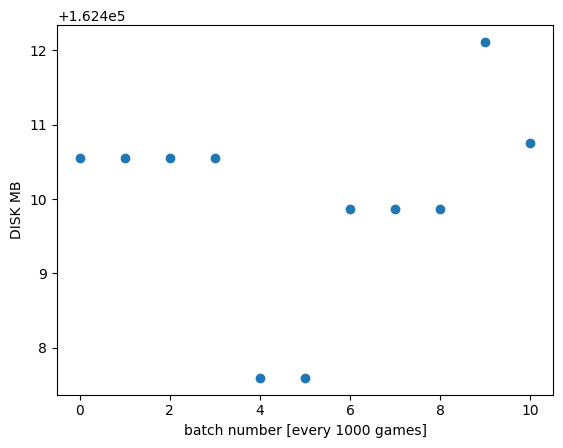

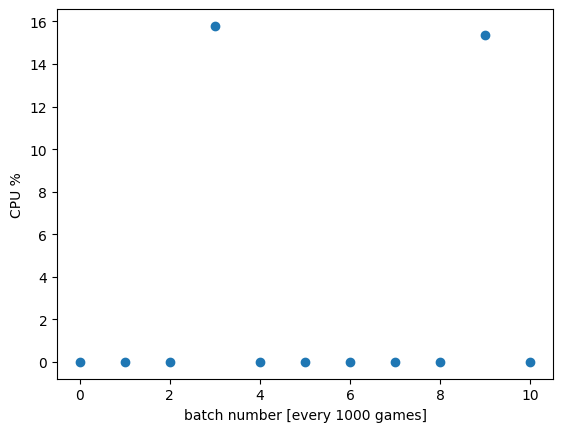

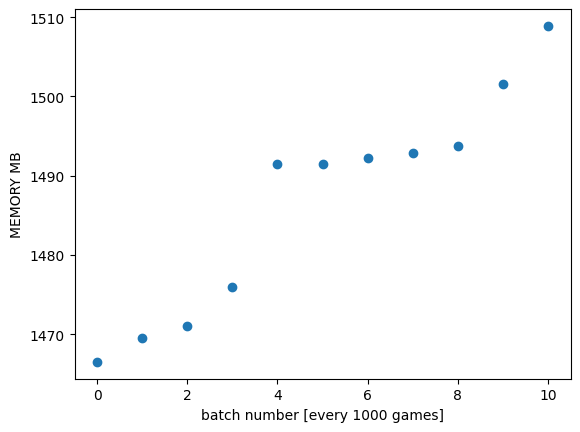

In [95]:
import matplotlib.pyplot as plt

batch_size = 1000

def plot(data, name):
    x = [i for i, _ in enumerate(data)]
    y = data

    plt.xlabel(f'batch number [every {batch_size} games]')
    plt.ylabel(name)
    plt.scatter(x, y)
    plt.show()


def plot_metric(metric, name, transform=lambda x: x):
    plot([transform(measurement[metric]) for measurement in measurements], name)

measurements.clear()

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

typesense_client.collections.create(schema)

collection = typesense_client.collections[collection_name]

measure_metrics()
for i in range(0, len(games), batch_size):
    print(f"Indexing batch {i // batch_size + 1}...")
    collection.documents.import_(games[i:i+batch_size], {
        'action': 'upsert',
    })
    measure_metrics()

plot_metric("system_disk_used_bytes", "DISK MB", lambda x: float(x) / 1024.0 / 1024.0)
plot_metric("system_cpu_active_percentage", "CPU %", lambda x: float(x))
plot_metric("system_memory_used_bytes", "MEMORY MB", lambda x: float(x) / 1024.0 / 1024.0)

7. Porównanie wsparcia da popularnych jezyków programowania oraz próba określenia łatwości korzystania z dokumentacji i jej kompletności